In [1]:
import perceval as pcvl
import perceval.components as comp
import numpy as np
import networkx as nx
from scipy.linalg import sqrtm
from perceval.algorithm import Sampler
from scipy.special import binom
import itertools
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
'''
Step 1: Get Matrix of overall graph  
Step 2: Get all possible sub graphs (of size K) 
Step 3: Calculate permanents for each sub graph
Step 4: Find the maximum permanents -> Density
'''

'\nStep 1: Get Matrix of overall graph  \nStep 2: Get all possible sub graphs (of size K) \nStep 3: Calculate permanents for each sub graph\nStep 4: Find the maximum permanents -> Density\n'

In [6]:
# Generate Graph
def gen_graph(n):
    G=nx.erdos_renyi_graph(n,0.5)
    G.inflow=1
    G.outflow=0
    #G=nx.scale_free_graph(n, alpha=0.41, beta=0.54, gamma=0.05, delta_in=0.2, delta_out=0, seed=None, initial_graph=None)
    #G2 = G.to_undirected()
    #G2.remove_edges_from(nx.selfloop_edges(G2))
    return G

'''def construct_B(graph, subG, k):
    G_n = len(graph.nodes)
    subG_n = len(subG)
    num_subgraphs = int(binom(G_n-subG_n, k-subG_n))
    
    nodes = list(G.nodes)
    test_nodes = [node for node in nodes if node not in subG]
    test_list = list(itertools.combinations(test_nodes, k-subG_n))

    poss_subg = [subG+list(i) for i in test_list]

    # Construction of B
    sub_m = [nx.convert_matrix.to_numpy_array(
        G.subgraph(sub_nodes)) for sub_nodes in poss_subg]
    B = np.zeros((k*num_subgraphs, k*num_subgraphs))
    for i, j in enumerate(sub_m):
        B[k*i:k*i+k, 0:k] = j
    return (B, poss_subg)'''



'def construct_B(graph, subG, k):\n    G_n = len(graph.nodes)\n    subG_n = len(subG)\n    num_subgraphs = int(binom(G_n-subG_n, k-subG_n))\n    \n    nodes = list(G.nodes)\n    test_nodes = [node for node in nodes if node not in subG]\n    test_list = list(itertools.combinations(test_nodes, k-subG_n))\n\n    poss_subg = [subG+list(i) for i in test_list]\n\n    # Construction of B\n    sub_m = [nx.convert_matrix.to_numpy_array(\n        G.subgraph(sub_nodes)) for sub_nodes in poss_subg]\n    B = np.zeros((k*num_subgraphs, k*num_subgraphs))\n    for i, j in enumerate(sub_m):\n        B[k*i:k*i+k, 0:k] = j\n    return (B, poss_subg)'

In [32]:
g = gen_graph(4)

In [35]:
total_nodes = len(g.nodes)
list_of_nodes_subgraph = len([2,3])
size_of_subgraph = 3

In [37]:
total_nodes-list_of_nodes_subgraph

2

In [38]:
size_of_subgraph-list_of_nodes_subgraph

1

In [ ]:
#The number of possible ways to choose 2 sub graphs from a set of 5 objects is equal to

In [36]:
int(binom(total_nodes-list_of_nodes_subgraph, size_of_subgraph-list_of_nodes_subgraph))

2

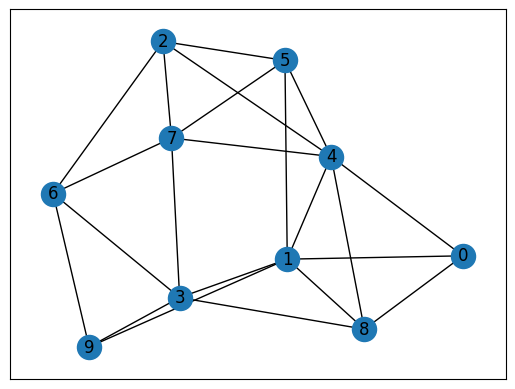

In [5]:
nx.draw_networkx(g)

In [ ]:
construct_B(g,

In [3]:
def to_unitary(A):
    ''' Input: graph A either as:
                                 an adjacency matrix of size mxm
                                 a networkX graph with m nodes
        Output: unitary with size 2mx2m
    '''

    if type(A) == type(nx.Graph()):
        A = nx.to_numpy_array(A)
    P1, D, V = np.linalg.svd(A)

    c = np.max(D)
    # if it is not complex, then np.sqrt will output nan in complex values
    An = np.matrix(A/c, dtype=complex)
    P = An
    m = len(An)
    Q = sqrtm(np.identity(m)-np.dot(An, An.conj().T))
    R = sqrtm(np.identity(m)-np.dot(An.conj().T, An))
    S = -An.conj().T
    Ubmat = np.bmat([[P, Q], [R, S]])
    Ubmat = Ubmat.real #to eliminate those 
    return (np.copy(Ubmat), c)

In [4]:
def input_state(m):
    '''input state for selection of our m modes
        returns |1,1,1,...,0,0,0> m ones and m zeros'''
    return np.append(np.ones(m), np.zeros(m)).astype(int)

In [5]:
# Post selection of samples with photons only on first half modes
def post_select(samples):
    ''''post select on states that have all modes from m to 2*m as vacuum
        can't have collision of first half'''
    a = []
    m = int(len(samples[0])/2)
    for state in samples:
        state = list(state)
        if all(ele == state[m-1] for ele in state[:m]) and state[m-1] == 1:
            # do not need to check if there is vacuum in the second half for several reasons!
            a.append(state)
    return a

In [6]:
def perm_estimation(G, nb_samples, Ns_min=0):
    if Ns_min == 0:
        Ns_min = nb_samples

    if type(G) == type(nx.Graph()):
        m = G.number_of_nodes()
    else:
        m = len(G)
    in_state = input_state(m)

    U, c = to_unitary(G)
    U_matrix_pcvl = pcvl.Matrix(U)
    unitary_component = comp.Unitary(U_matrix_pcvl)
    proc = pcvl.Processor("CliffordClifford2017", unitary_component)
    proc.with_input(pcvl.BasicState(in_state))

    samples_accepted = []
    i = 0
    sampler = Sampler(proc)
    while len(samples_accepted) < Ns_min:
        samples = list(sampler.samples(nb_samples)['results'])
        samples_accepted += post_select(samples)
        i = i+1
    #print("Total number of samples: ", nb_samples*i)
    #print("Number of samples post:", len(samples_accepted))
    perm = (c**m)*np.sqrt(len(samples_accepted)/(nb_samples*i))
    return perm, samples

In [7]:
# Functions to generate the subgraphs to test
def construct_B(G, subG, k):
    ''' inputs: 
                G - networkX graph 
                subG - list of nodes for selected subgraph
                k - integer for size of subgraph to find
        return:
                matrix B containing all possible subgraphs of size k - dimensions are k*len(sub_m), k*len(sub_m)'''

    G_n = len(G.nodes)
    subG_n = len(subG)
    num_subgraphs = int(binom(G_n-subG_n, k-subG_n))
    #print("Number of combinations for subgraphs:", num_subgraphs)

    nodes = list(G.nodes)
    test_nodes = [node for node in nodes if node not in subG]
    test_list = list(itertools.combinations(test_nodes, k-subG_n))

    poss_subg = [subG+list(i) for i in test_list]

    # Construction of B
    sub_m = [nx.convert_matrix.to_numpy_array(
        G.subgraph(sub_nodes)) for sub_nodes in poss_subg]
    B = np.zeros((k*num_subgraphs, k*num_subgraphs))
    for i, j in enumerate(sub_m):
        B[k*i:k*i+k, 0:k] = j
    return (B, poss_subg)

In [8]:
def densest_subgraphs(G, seed, k, nb_samples, Ns_min=100):
    '''Input: G - networkX graph to test 
              Ns - number of samples to generate with quantum device
              seed - subgraph identified from optimized classical algorithm
    return: subgraphs by order of selection'''

    # Initialization and preparing the device
    B = construct_B(G, seed, k)
    in_state = input_DS(int(len(B[0])/k), k)
    U, c = to_unitary(B[0])

    unitary_component = comp.Unitary(pcvl.Matrix(U))
    proc = pcvl.Processor("CliffordClifford2017", unitary_component)
    proc.with_input(pcvl.BasicState(in_state))

    # generating samples
    samples = []
    i = 0
    sampler = Sampler(proc)
    while len(samples) < Ns_min:
        samples_device = sampler.samples(nb_samples)['results']
        new_generation_samples = post_selectionDS(samples_device, k)
        samples += new_generation_samples
        i = i+1

    timesG = np.zeros(len(B[1]))
    #print("Number of samples: ", len(samples), "\nTotal samples generated:", nb_samples*i)
    for sample in samples:
        indexG = list(sample).index(1)
        timesG[int(indexG/k)] = timesG[int(indexG/k)]+1
    return sorted(zip(timesG, B[1]), reverse=True)

In [9]:
def input_DS(m, k):
    '''input state for selection columns
             m - number of subgraphs
             k - size of each subgraph (size to identify)
        returns |1,1,1,...,0,0,0> k ones and k*m-k zeros'''
    return np.append(np.append(np.ones(k), np.zeros(k*m-k)), np.zeros(k*m)).astype(int)

In [10]:
def post_selectionDS(samples, k):
    n_subg = int(len(samples[0])/2/k)
    accepted = [sample for sample in samples for i in range(n_subg) if all(sample[k*i:k*i+k]) == 1]
    return accepted

In [11]:
def create_graph(n,p):
    graph = nx.erdos_renyi_graph(n=7,p=0.7)
    graph.inflow=1
    graph.outflow=0
    return graph

In [12]:
def prune_graphlinks(netw):
    while True :
        l=[]
        #print(netw.number_of_nodes())
        for i in netw.nodes():
            if netw.degree[i]<=1:
                l.append(i)
        assert (netw.inflow not in l) and (netw.outflow not in l) 
        if l:
            #print(l)
            netw.remove_nodes_from(l)
        else:
            break

def get_flow(netw):
    """
    Returns the matrix of fluxes M and flow potentials F.
    
    An alternative of the following code is to compute the Laplacian matrix
    using the built-in L = laplacian(G) function. However, for small networks
    (i.e. N0 < 1600), this code seems faster.
    (need further investigations for assessing runtime differences).
    """
    prune_graphlinks(netw)
    
    
    # Preallocs:
    #sized = netw.graph.Nodes.shape[0]
    sized = netw.number_of_nodes()
    
    # For Matlab 'graph' adaptation, just re-create the adjacency matrix:
    netw.adjm = nx.adjacency_matrix(netw).todense()
    netw.adjm[netw.adjm > 1] = 1
    
    
    # Use Python version:
    P, S = prepare_linsys(netw, sized)
    
    # Remove both inflow and outflow entries from P:
    #P = np.delete(np.delete(P, netw.inflow, 0), netw.inflow, 1)
    P = np.delete(np.delete(P, netw.outflow, 0), netw.outflow, 1)
    #S = np.delete(S, [netw.inflow, netw.outflow])
    S = np.delete(S, [netw.outflow])
    
    # Solve the linear system:
    FF = np.linalg.solve(P, S)
    # Re-insert inflow and outflow nodes:
    F = np.zeros(sized)
    #F[:min([netw.inflow, netw.outflow])-1] = FF[:min([netw.inflow, netw.outflow])-1]
    #F[min([netw.inflow, netw.outflow])+1:max([netw.inflow, netw.outflow])-1] = FF[min([netw.inflow, netw.outflow]):max([netw.inflow, netw.outflow])-2]
    #F[max([netw.inflow, netw.outflow])+1:] = FF[max([netw.inflow, netw.outflow])-1:]
    F[1:]=FF[:]
    
    
    if min([netw.inflow, netw.outflow]) == netw.inflow:
        F[min([netw.inflow, netw.outflow])] = 1
        F[max([netw.inflow, netw.outflow])] = 0
    else:
        F[min([netw.inflow, netw.outflow])] = 0
        F[max([netw.inflow, netw.outflow])] = 1
    
    F = F.T
    
    # Then compute the fluxes matrix M, according to F (flow potentials):
    M = compute_q(netw, sized, F)
    
    return F, M

def compute_q(netw, sized, F):
    """
    Compute the fluxes matrix M, according to F (flow potentials).
    """
    M = np.zeros((sized, sized))
    
    for i in range(netw.adjm.shape[0]):
        #idx = netw.adjm[i] == 1
        idx = [j for j in range(sized) if netw.adjm[i,j] == 1]
        #D = netw.dis_eucl[i, idx]
        D=1
        for j in idx:
             M[i, j] = -(F[i] - F[j]) / D

    return M

In [13]:
def gen_graph(n):
    G=nx.erdos_renyi_graph(n,0.5)
    G.inflow=1
    G.outflow=0
    
    #G=nx.scale_free_graph(n, alpha=0.41, beta=0.54, gamma=0.05, delta_in=0.2, delta_out=0, seed=None, initial_graph=None)
    #G2 = G.to_undirected()
    #G2.remove_edges_from(nx.selfloop_edges(G2))
    
    return G
    #return G2

def gen_graph_scalefree(n):
    G=nx.scale_free_graph(n, alpha=0.41, beta=0.54, gamma=0.05, delta_in=0.2, delta_out=0, seed=None, initial_graph=None)
    G2 = G.to_undirected()
    G2.remove_edges_from(nx.selfloop_edges(G2))
    
    G2.inflow=1
    G2.outflow=0
    return G2

def get_Q(netw):
    [F,M]=get_flow(netw)
    (idxi,idxj)=np.where(M==np.min(np.abs(M[np.nonzero(M)])))
    return np.abs(M[1].sum()) , (idxi[0],idxj[0])

def prepare_linsys(netw, sized):
    """
    Prepare the linear system for solving.
    """
    P = np.zeros((sized, sized))
    S = np.zeros(sized)
    nodes = list(netw.nodes())
    for i in range(netw.adjm.shape[0]):
        idx = [j for j in range(sized) if netw.adjm[i,j] == 1]
        
        for j in idx:
            P[i,j] = -1
        
        P[i,i]=len(idx)
     
    S[nodes.index(netw.inflow)]=1

    return P, S

In [14]:
def delete_random_edge(graph):
    edges = list(graph.edges)

    # random edge choice
    chosen_edge = random.choice(edges)
    graph.remove_edge(chosen_edge[0], chosen_edge[1])

    return graph

def delete_weakest_link(graph,chosen_edge):
    nodes = list(graph.nodes())
    graph.remove_edge(nodes[chosen_edge[0]], nodes[chosen_edge[1]])
    return graph

def delete_random_densest_edge(graph):
    nodes=dsd.exact_densest(graph)[0]
    edges = list(graph.edges)
    #print(edges)
    selection=[]
    for l in edges:
        if l[0] in nodes and l[1] in nodes:
            selection.append((l[0],l[1]))
    chosen_edge = random.choice(selection)
    graph.remove_edge(chosen_edge[0], chosen_edge[1])
    return graph

In [15]:
def delete_weakest_link(graph,chosen_edge):
    nodes = list(graph.nodes())
    graph.remove_edge(nodes[chosen_edge[0]], nodes[chosen_edge[1]])
    return graph

#### Visual

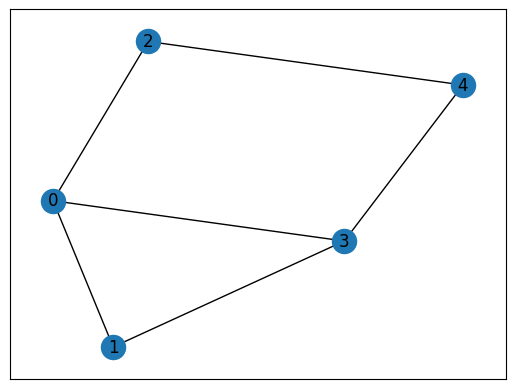

In [21]:
g = gen_graph(n=5)
nx.draw_networkx(g)

In [22]:
num_iterations = 5

In [23]:
total_flux = []
k = 2
for i in tqdm(range(num_iterations)):
    res = densest_subgraphs(g, seed=[np.random.choice(len(g.nodes))], k=k, nb_samples=100, Ns_min=100)
    delete_weakest_link(g,res[0][-1])
    total_flux.append(get_Q(g)[0])

 20%|█████████                                    | 1/5 [00:00<00:00, 24.10it/s]


IndexError: list index out of range

In [ ]:
plt.plot(total_flux)

#### 3) Calculating potential and flux